<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />

# Worksheet 11.0 Attacking AI

In this lab, we will learn how to use the Adversarial Robustness Toolkit (ART) to launch various attacks against models. The first attack you will launch will be to create adversarial examples from a model.  These examples could be used to defeat a model, or control the model's behavior.

The documentation for ART can be found here: https://github.com/Trusted-AI/adversarial-robustness-toolbox/tree/main

In [1]:
import numpy as np
import pandas as pd
import pickle
from art.attacks.evasion import DecisionTreeAttack, HopSkipJump
from art.estimators.classification import SklearnClassifier, BlackBoxClassifier
from art.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn import metrics
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env-jnb/lib/python3.10/site-packages/art/estimators/certification/__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


## Decision Tree Attack
In this example, we are going to use the ART to attack a decision tree. The goal is to create adversarial examples which could be used to control the output of the model.  

Due to the nature of decision trees, it is not necessary to use gradient descent to discover adversarial examples and instead, it can be accomplished by tree traversals. This attack is a whitebox attack in that you need to have access to the actual model. 

This methodology was described in a paper by Papernot et al. in https://arxiv.org/abs/1605.07277. You can see this code in action here: https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/attack_decision_tree.ipynb.

First we're going to load the model from a pickle file. 

In [2]:
# Load the classifier from the pickle file
clf = pickle.load(open("../data/dga_decision_tree.sav", "rb"))

We will also need some training data.  In this case, we'll use the data that was used to train the original model, but this is not necessary. 

In [3]:
df = pd.read_csv('../data/dga_features_final_df.csv')
y = df['isDGA']
X = df.drop(['isDGA'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Step 1:  Create the ART Classifier
As a first step, we need to use ART to create an "adversarial" classifier.  Use the `SklearnClassifier` module from ART. 

In [4]:
# Your code here ...
adversarial_classifier = SklearnClassifier(model=clf)

### Step 2:  Attack!!!
Now that you've created an adversarial classifier the next step is to train that adversarial classifier.  Use the `DecisionTreeAttack` module in ART to launch an attack, then call the `generate()` with the `feature_matrix_train` and `target_train` datasets.  The `generate()` method can be called either with only the feature matrix alone or you can call it with a list of desired targets.  

For our example, let's say that we want all the results to be classified as legitimate, we're going to pass it a numpy array of 1500 `0` for a target vector.


Note: You will have to call the `.to_numpy()` methods on these datasets when you pass them to ART.


This step generates a lot of future warnings. For this exercise we have suppressed them, however scikit-learn will throw warnings when you mix numpy arrays and dataframes.  The way to avoid this is to actually train your models on numpy arrays.  To do that, during the training process, convert the dataframe to a numpy array with the `.to_numpy()` method.

In [5]:
# Here's an array of all zeros to fool the classifier
all_legit = np.array([0] * 1500)

# First create the DecisionTreeAttack
attack = DecisionTreeAttack(adversarial_classifier)

# Then run the generate function to generate adversarial examples.
adversarial_data = attack.generate(X_train.to_numpy(), all_legit)

Decision tree attack:   0%|          | 0/1500 [00:00<?, ?it/s]

### Step 3:  Evaluate the Performance
At this point you should have a dataset of adversarial examples that produce exclusively legit classifications.  Now try running that through the original classifier and making a classification report to see how we did.

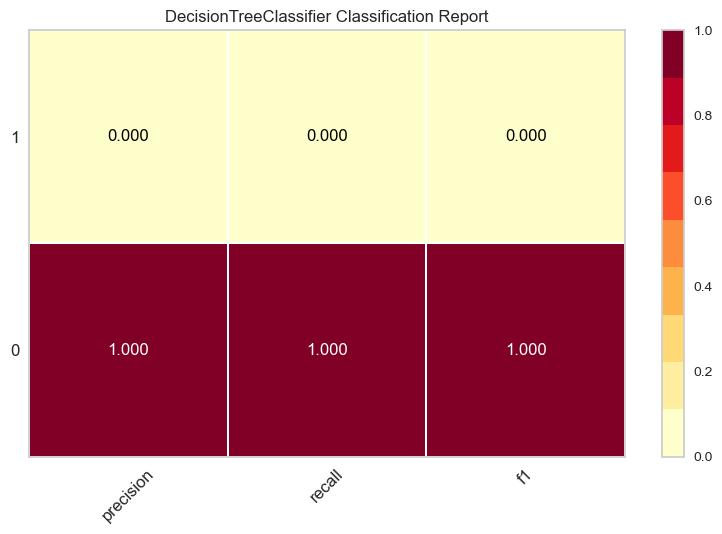

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [6]:
adversarial_preds = clf.predict(adversarial_data)

viz = ClassificationReport(clf)
viz.fit(X_train, y_train)
viz.score(adversarial_data, adversarial_preds)
viz.show()

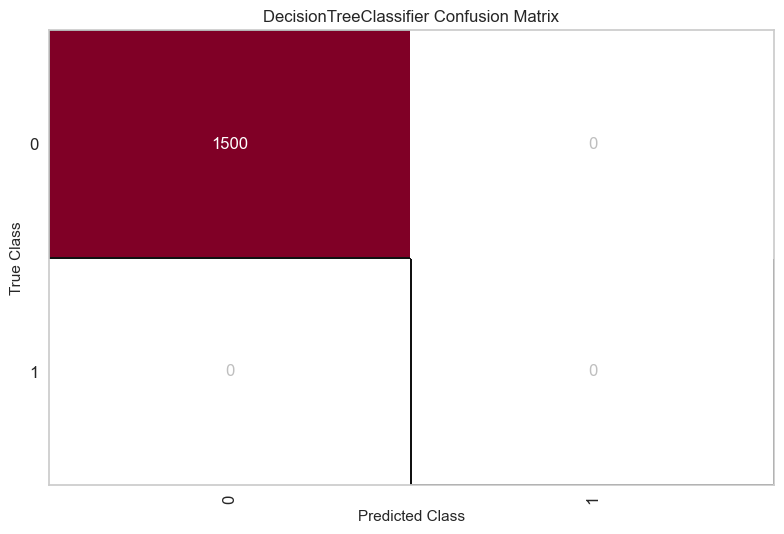

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [7]:
viz = ConfusionMatrix(clf)
viz.fit(X_train, y_train)
viz.score(adversarial_data, adversarial_preds)
viz.show()

If you did this correctly, you should get predictions that are entirely of the `0` class.  This shows how you are able to generate adverarial data that can be crafted to direct the decisions of a model.

## BlackBox Adversarial Attack
Now that you've successfully launched a white box adversarial attack, let's try a blackbox attack. We're going to use the `HopSkipJump` attack from Jianbo et al. (2019). This is a powerful black-box attack that only requires final class prediction, and is an advanced version of the boundary attack.

Paper link: https://arxiv.org/abs/1904.02144

In order to execute this attack, we will need a `predict()` function which calls a trained model and returns the predictions. In our example, the `predict()` function is simply a wrapper for our trained classifier, however, this same technique could be used with a true blackbox model where only the predictions are accessible. In that case, the `predict()` function would contain API calls or something similar.

In [8]:
def predict(x):
    '''
    Call the model and return the predictions.  This function could contain calls to a true 
    blackbox model, but in this example, is calling our pre-trained model.
    '''
    x = np.array(x)
    return to_categorical(clf.predict(x), nb_classes=2)

### Step 1:  Create the BlackBox Classifier
In order to execute the attack we need to first create a `BlackBoxClassifier`.  At a minimum, we need to pass the predict function, the number of features and the number of possible classes.

In [9]:
blackbox_clf = BlackBoxClassifier(predict, X_train.iloc(0)[0].shape, nb_classes=2)

### Step 2:  ATTACK!!  Generate Adversarial Examples
The next step is to create the `HopSkipJump` object to launch the attack.  This follows a similar pattern as the previous attack where you create the `attack` object, then call the `generate()` method passing the testing features (`feature_matrix_test`).  This will generate an array of adversarial examples.  

For our use case, let's say that we want to generate adversarial examples that skew towards one class. In the `HopSkipJump` object, set `targeted=True` which forces the attack to generate examples for one class only. 


NOTE: You will have to convert the testing features to a numpy array like this:
```python
feature_matrix_test.to_numpy()
```

In [10]:
# Create the attack object.
attack = HopSkipJump(classifier=blackbox_clf,targeted=True, norm=np.inf, max_iter=100, max_eval=100,
                     init_eval=100, init_size=100)

In [11]:
# Now generate the adversarial examples
adversarial_data_blackbox = attack.generate(X_test.to_numpy(), y_test.to_numpy())

HopSkipJump:   0%|          | 0/500 [00:00<?, ?it/s]

### Step 3:  Evaluate the Attack
Now that you have a set of adversarial data, let's make some predictions with that data and see how effective it is in predicting the model output.  You won't be able to use Yellowbrick here because the `BlackBoxClassifier` does not implement the `fit()` method. 

For this final step, make the predictions, then create a confusion matrix of this data to evaluate your BlackBox model's performance.

In [12]:
# First make some predictions using the adversarial data you generated
adversarial_predictions = blackbox_clf.predict(adversarial_data_blackbox)[:,1]

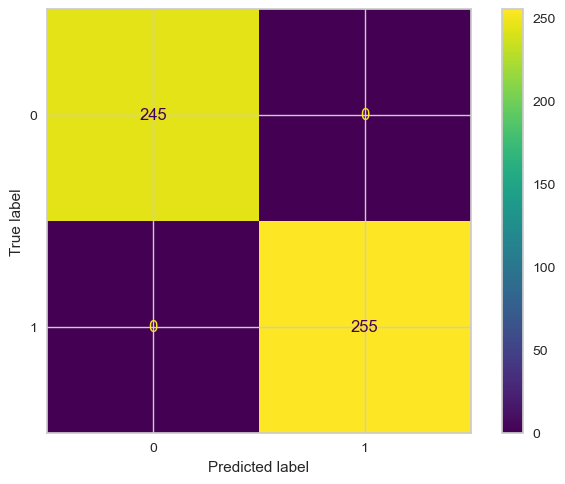

In [13]:
# Now create a confusion matrix
confusion_matrix= metrics.confusion_matrix(y_test, adversarial_predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

How did the model do?  If you did this correctly, you should have a blackbox classifier that perfectly classified the adversarial data equally into both the legit and dga class. 